In [15]:
# Bibliotecas necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# We will use some methods from the sklearn module
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

import scipy.stats as stats
from scipy.stats import bartlett, shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display, Markdown

https://cienciadedatos.net/documentos/py10b-regresion-lineal-multiple-python

### Datos

In [5]:
# Leer archivo csv

raw_data_url = "Datos.csv"

# Leer el archivo CSV
df = pd.read_csv(raw_data_url)

# Mostrar las primeras filas del DataFrame
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       59 non-null     float64
 1   X1      59 non-null     float64
 2   X2      59 non-null     float64
 3   X3      59 non-null     float64
 4   X4      59 non-null     float64
 5   X5      59 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 2.9 KB


None

,Y,X1,X2,X3,X4,X5
0,4.8,9.84,62.2,12.0,82.3,600
1,5.0,11.03,49.9,19.7,102.1,318
2,4.4,11.65,54.5,18.6,96.1,248
3,3.7,8.48,51.1,12.1,92.8,166
4,5.5,11.08,50.2,18.6,63.6,387


### Relacion entre las variables

In [6]:
# Correlación lineal entre variables numéricas
# ==============================================================================
corr_matrix = df.corr(method='pearson')
tril = np.tril(np.ones(corr_matrix.shape)).astype(bool)
corr_matrix[tril] = np.nan
corr_matrix_tidy = corr_matrix.stack().reset_index(name='r')
corr_matrix_tidy = corr_matrix_tidy.rename(columns={'level_0': 'variable_1', 'level_1': 'variable_2'})
corr_matrix_tidy = corr_matrix_tidy.dropna()
corr_matrix_tidy['r_abs'] = corr_matrix_tidy['r'].abs()
corr_matrix_tidy = corr_matrix_tidy.sort_values('r_abs', ascending=False).reset_index(drop=True)
corr_matrix_tidy

,variable_1,variable_2,r,r_abs
0,X1,X5,0.517463,0.517463
1,Y,X1,0.514586,0.514586
2,Y,X5,0.460360,0.460360
3,X3,X4,0.459671,0.459671
4,Y,X3,0.442119,0.442119
5,Y,X4,0.433135,0.433135
6,X1,X4,0.334557,0.334557
7,X1,X3,0.305234,0.305234
8,X2,X3,-0.279236,0.279236
9,X3,X5,0.192034,0.192034


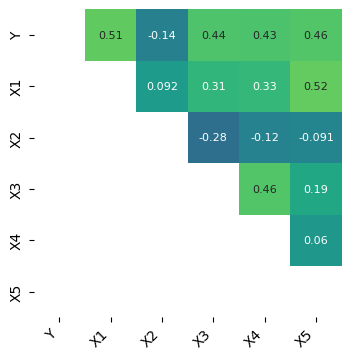

In [7]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = "viridis",
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)
ax.tick_params(labelsize = 10)

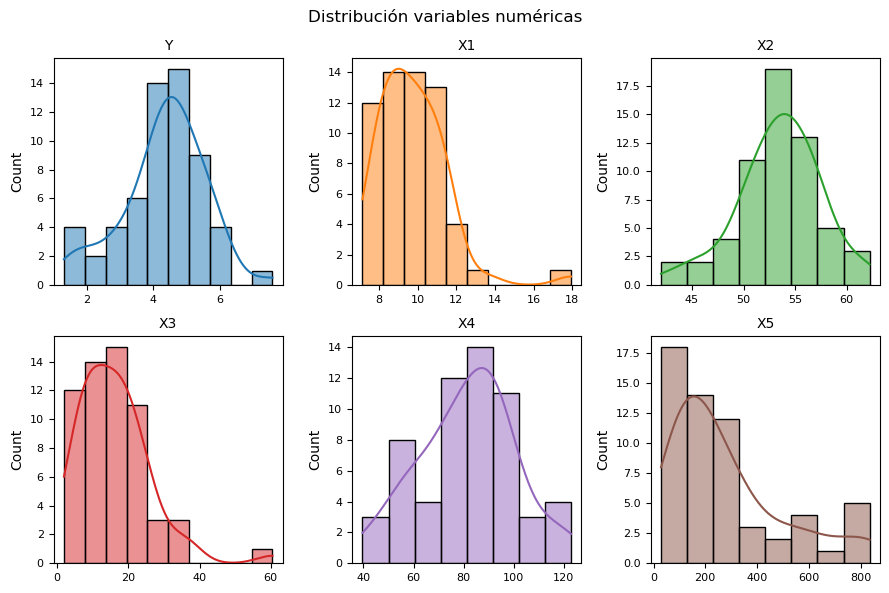

In [12]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=np.number).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10)
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")
   
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 12);

### Ajuste del modelo

In [16]:
# Ajsute del modelo utilizando el modo fórmula (similar a R)
# ==============================================================================
# Para ajustar el modelo utilizando el modo fórmula, es necesario que los datos
# estén almacenados en un único dataframe.

modelo = smf.ols(
     formula = 'Y ~ X1 + X2 + X3 + X4 + X5',
     data = df
)
modelo_res = modelo.fit()
print(modelo_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     8.593
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           5.17e-06
Time:                        23:21:18   Log-Likelihood:                -78.282
No. Observations:                  59   AIC:                             168.6
Df Residuals:                      53   BIC:                             181.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5143      1.898      0.798      0.4

In [13]:
# Ajuste del modelo utilizando el modo fórmula (similar a R)

x = df[["X1", "X2","X3", "X4","X5"]]
y = df["Y"]

x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
predictions_statsmodels = model.predict(x)
summary = model.summary()

print(summary)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     8.593
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           5.17e-06
Time:                        23:17:40   Log-Likelihood:                -78.282
No. Observations:                  59   AIC:                             168.6
Df Residuals:                      53   BIC:                             181.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5143      1.898      0.798      0.4

### Seleccion de los mejores predictores

In [17]:
# Funciones de selecciçon forward y backward para modelos lineales de statsmodels
# ==============================================================================

def forward_selection(
    X: pd.DataFrame,
    y: pd.Series,
    criterio: str='aic',
    add_constant: bool=True,
    verbose: bool=True
)-> list:
    
    """
    Realiza un procedimiento de selección de variables hacia adelante (forward)
    utilizando como criterio de bondad la métrica especificada. El procedimiento
    se detiene cuando no es posible mejorar más el modelo añadiendo variables.

    Parameters
    ----------
    X: pd.DataFrame
        Matriz de predictores
    y: pd.Series
        Variable respuesta
    metrica: str, default='aic'
        Métrica utilizada para seleccionar las variables. Debe ser una de las
        siguientes opciones: 'aic', 'bic', 'rsquared_adj'.
    add_constant: bool, default=True
        Si `True` añade una columna de 1s a la matriz de predictores con el
        con el nombre de intercept.
    verbose: bool, default=True
        Si `True` muestra por pantalla los resultados de cada iteración.
    
    Returns
    -------
    seleccion: list
        Lista con las variables seleccionadas.
    """

    if add_constant:
        X = sm.add_constant(X, prepend=True).rename(columns={'const':'intercept'})

    restantes = X.columns.to_list()
    seleccion = []
    if criterio == 'rsquared_adj':
        mejor_metrica = -np.inf
        ultima_metrica = -np.inf
    else:
        mejor_metrica = np.inf
        ultima_metrica = np.inf

    while restantes:
        metricas = []
        for candidata in restantes:
            seleccion_temp = seleccion + [candidata]
            modelo  = sm.OLS(endog=y, exog=X[seleccion_temp])
            modelo_res = modelo.fit()
            metrica = getattr(modelo_res, criterio)
            metricas.append(metrica)
        if criterio == 'rsquared_adj':
            mejor_metrica = max(metricas)
            if mejor_metrica > ultima_metrica:
                mejor_variable = restantes[np.argmax(metricas)]
            else:
                break
        else:
            mejor_metrica = min(metricas)
            if mejor_metrica < ultima_metrica:
                mejor_variable = restantes[np.argmin(metricas)]
            else:
                break
                
        seleccion.append(mejor_variable)
        restantes.remove(mejor_variable)
        ultima_metrica = mejor_metrica

        if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    return sorted(seleccion)


def backward_selection(
    X: pd.DataFrame,
    y: pd.Series,
    criterio: str='aic',
    add_constant: bool=True,
    verbose: bool=True
)-> list:
    
    """
    Realiza un procedimiento de selección de variables hacia atrás (backward) 
    utilizando como criterio de bondad la métrica especificada. El procedimiento
    se detiene cuando no es posible mejorar más el modelo eliminando variables.

    Parameters
    ----------
    X: pd.DataFrame
        Matriz de predictores
    y: pd.Series
        Variable respuesta
    metrica: str, default='aic'
        Métrica utilizada para seleccionar las variables. Debe ser una de las
        siguientes opciones: 'aic', 'bic', 'rsquared_adj'.
    add_constant: bool, default=True
        Si `True` añade una columna de 1s a la matriz de predictores con el
        con el nombre de intercept.
    verbose: bool, default=True
        Si `True` muestra por pantalla los resultados de cada iteración.
    
    Returns
    -------
    seleccion: list
        Lista con las variables seleccionadas.
    """

    if add_constant:
        X = sm.add_constant(X, prepend=True).rename(columns={'const':'intercept'})

    # Se inicia con todas las variables como predictores
    seleccion = X.columns.to_list()
    modelo  = sm.OLS(endog=y, exog=X[seleccion])
    modelo_res = modelo.fit()
    ultima_metrica = getattr(modelo_res, criterio)
    mejor_metrica = ultima_metrica
    if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    while seleccion:
        metricas = []
        for candidata in seleccion:
            seleccion_temp = seleccion.copy()
            seleccion_temp.remove(candidata)
            modelo  = sm.OLS(endog=y, exog=X[seleccion_temp])
            modelo_res = modelo.fit()
            metrica = getattr(modelo_res, criterio)
            metricas.append(metrica)
        if criterio == 'rsquared_adj':
            mejor_metrica = max(metricas)
            if mejor_metrica > ultima_metrica:
                peor_variable = seleccion[np.argmax(metricas)]
            else:
                break
        else:
            mejor_metrica = min(metricas)
            if mejor_metrica < ultima_metrica:
                peor_variable = seleccion[np.argmin(metricas)]
            else:
                break
                
        seleccion.remove(peor_variable)
        ultima_metrica = mejor_metrica

        if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    return sorted(seleccion)

In [19]:
# Selección de variables hacia forward
# ==============================================================================
predictores = forward_selection(
    X            = x,
    y            = y,
    criterio     = 'aic',
    add_constant = False, # Ya se le añadió anteriormente
    verbose      = True
)
predictores

variables: ['X1'] | aic: 176.605
variables: ['X1', 'X4'] | aic: 170.948
variables: ['X1', 'X4', 'X5'] | aic: 166.434
variables: ['X1', 'X4', 'X5', 'X3'] | aic: 165.600


['X1', 'X3', 'X4', 'X5']

In [20]:
predictores= backward_selection(
    X            = x,
    y            = y,
    criterio     = 'aic',
    add_constant = False, # Ya se le añadió anteriormente
    verbose      = True
)
predictores

variables: ['const', 'X1', 'X2', 'X3', 'X4', 'X5'] | aic: 168.565
variables: ['const', 'X1', 'X3', 'X4', 'X5'] | aic: 166.828
variables: ['X1', 'X3', 'X4', 'X5'] | aic: 165.600


['X1', 'X3', 'X4', 'X5']

In [21]:
# Entrenamiento del modelo con las variables seleccionadas
# ==============================================================================
modelo_final  = sm.OLS(endog=y, exog=x[predictores])
modelo_final_res = modelo_final.fit()
print(modelo_final_res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                              316.1
Date:                Tue, 01 Oct 2024   Prob (F-statistic):                    3.08e-37
Time:                        23:26:52   Log-Likelihood:                         -78.800
No. Observations:                  59   AIC:                                      165.6
Df Residuals:                      55   BIC:                                      173.9
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [23]:
# Selección de predictores con sklearn SequentialFeatureSelector
# ==============================================================================
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

modelo = LinearRegression()
sfs = SequentialFeatureSelector(
    modelo,
    n_features_to_select = 'auto',
    direction            = 'forward',
    scoring              = 'r2',
    cv                   = 5
)
sfs.fit(x, y)
sfs.get_feature_names_out().tolist()

['X1', 'X3', 'X5']

### Diagnostico de residuos

In [24]:
# Residuos del modelo
# ==============================================================================
residuos = modelo_final_res.resid

# prediciones de entrenamiento
# ==============================================================================
prediccion_train = modelo_final_res.predict(x[predictores])

### Inspeccion visual

c:\Users\Usuario\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


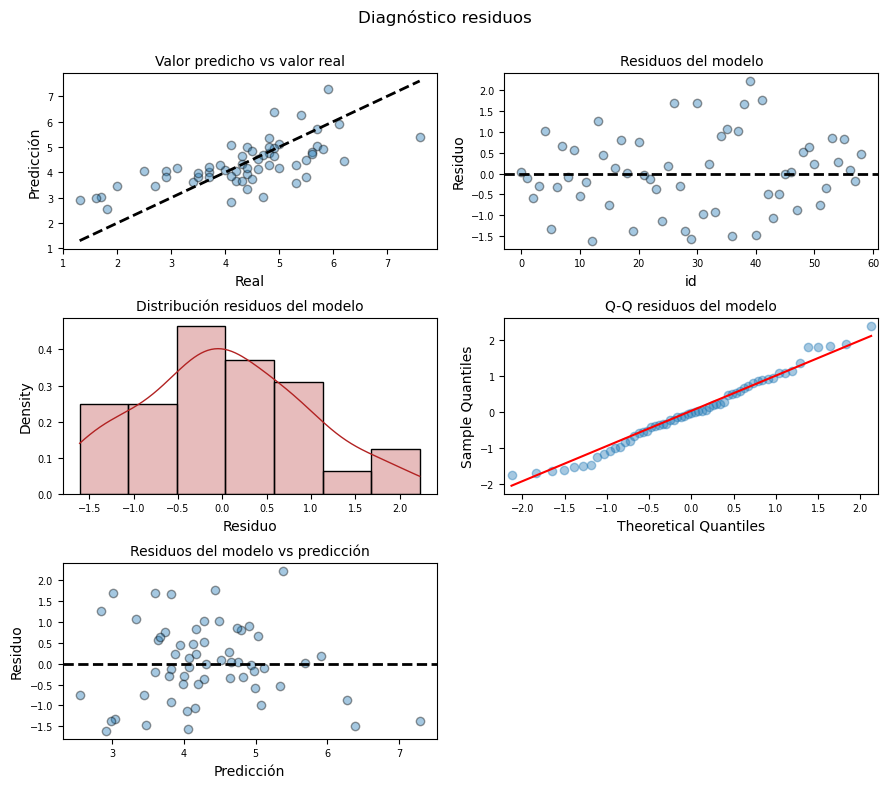

In [27]:
# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize=10)
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y))), residuos, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 1].axhline(y=0, linestyle='--', color='black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10)
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data     = residuos,
    stat     = "density",
    kde      = True,
    line_kws = {'linewidth': 1},
    color    = "firebrick",
    alpha    = 0.3,
    ax       = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize=10)
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)

sm.qqplot(
    residuos,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize=10)
axes[1, 1].tick_params(labelsize=7)

axes[2, 0].scatter(prediccion_train, residuos, edgecolors=(0, 0, 0), alpha=0.4)
axes[2, 0].axhline(y=0, linestyle='--', color='black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize=10)
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize=7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize=12);


### Test de normalidad

In [28]:
# Normalidad de los residuos Shapiro-Wilk test
# ==============================================================================
shapiro_test = stats.shapiro(residuos)
print(f"Test Shapiro-Wilk: estadístico = {shapiro_test[0]}, p-value = {shapiro_test[1]}")

# Normalidad de los residuos D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(residuos)
print(f"Test D'Agostino's K-squared: estadístico = {k2}, p-value = {p_value}")

Test Shapiro-Wilk: estadístico = 0.9797856211662292, p-value = 0.4309631884098053
Test D'Agostino's K-squared: estadístico = 0.9147917324812063, p-value = 0.6329297349482401


### Homodecasticidad

In [30]:
# Prueba de Breusch-Pagan
# ==============================================================================
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuos, x[predictores])
print(f"Estadítico= {fvalue}, p-value = {f_p_value}")

Estadítico= 8.964892141709392, p-value = 1.1984630120739359e-05


### Multicolinealidad (Inflación de varianza VIF)

In [32]:
# Correlación entre predictores numéricos
# ==============================================================================
corr_matrix = x[predictores].corr(method='pearson')
tril = np.tril(np.ones(corr_matrix.shape)).astype(bool)
corr_matrix[tril] = np.nan
corr_matrix_tidy = corr_matrix.stack().reset_index(name='r')
corr_matrix_tidy = corr_matrix_tidy.rename(columns={'level_0': 'variable_1', 'level_1': 'variable_2'})
corr_matrix_tidy = corr_matrix_tidy.dropna()
corr_matrix_tidy['r_abs'] = corr_matrix_tidy['r'].abs()
corr_matrix_tidy = corr_matrix_tidy.sort_values('r_abs', ascending=False).reset_index(drop=True)
corr_matrix_tidy

,variable_1,variable_2,r,r_abs
0,X1,X5,0.517463,0.517463
1,X3,X4,0.459671,0.459671
2,X1,X4,0.334557,0.334557
3,X1,X3,0.305234,0.305234
4,X3,X5,0.192034,0.192034
5,X4,X5,0.059914,0.059914


In [35]:
# Cálculo del VIF
# ==============================================================================
vif = pd.DataFrame()
vif["variables"] = x[predictores].columns
vif["VIF"] = [variance_inflation_factor(x[predictores].values, i) for i in range(x[predictores].shape[1])]
vif

NameError: name 'variance_inflation_factor' is not defined